# 0.0 SQL & IMPORTS

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scikitplot as skplt
import boruta as bt
import pickle

from IPython.display import Image
from IPython.core.display import HTML
from matplotlib import pyplot as plt
from scipy import stats
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm

In [2]:
# Funções

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
   

    display( HTML( '<style>.container { width:80% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [4]:
df_raw = pd.read_csv('C:/Users/Pedro/repos/health_insurance_cross_sell/pa004_health_insurance_cross_sell/health_insurance_cross-sell/data/raw/train.csv')

In [6]:
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 1.0 DESCRIÇÃO DOS DADOS

In [7]:
df1 = df_raw.copy()

In [8]:
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response']

df1.columns = cols_new

In [9]:
# Verificando características do DataFrame
df1.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   driving_license       381109 non-null  int64  
 4   region_code           381109 non-null  float64
 5   previously_insured    381109 non-null  int64  
 6   vehicle_age           381109 non-null  object 
 7   vehicle_damage        381109 non-null  object 
 8   annual_premium        381109 non-null  float64
 9   policy_sales_channel  381109 non-null  float64
 10  vintage               381109 non-null  int64  
 11  response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [10]:
# Printando numero de linhas e colunas
print('Número de colunas: {}'.format(df1.shape[1]))
print('Número de linhas: {}'.format(df1.shape[0]))

Número de colunas: 12
Número de linhas: 381109


In [11]:
# Estatistica Descritiva
df_statistics = df1[['age', 'annual_premium', 'vintage', 'driving_license']]

# Central Tendency - mean, median
ct1 = pd.DataFrame( df_statistics.apply( np.mean ) ).T
ct2 = pd.DataFrame( df_statistics.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( df_statistics.apply( np.std ) ).T
d2 = pd.DataFrame( df_statistics.apply( min ) ).T
d3 = pd.DataFrame( df_statistics.apply( max ) ).T
d4 = pd.DataFrame( df_statistics.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( df_statistics.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( df_statistics.apply( lambda x: x.kurtosis() ) ).T

# Concat
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.0,85.0,65.0,38.822584,36.0,15.511591,0.672539,-0.565655
1,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087,34.004569
2,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,0.003030,-1.200688
3,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-21.595182,464.354302


In [12]:
# Verificando o balanceamento da variável resposta
df_response = df1[['response', 'id']].groupby('response').count().reset_index()
df_response

,response,id
0,0,334399
1,1,46710


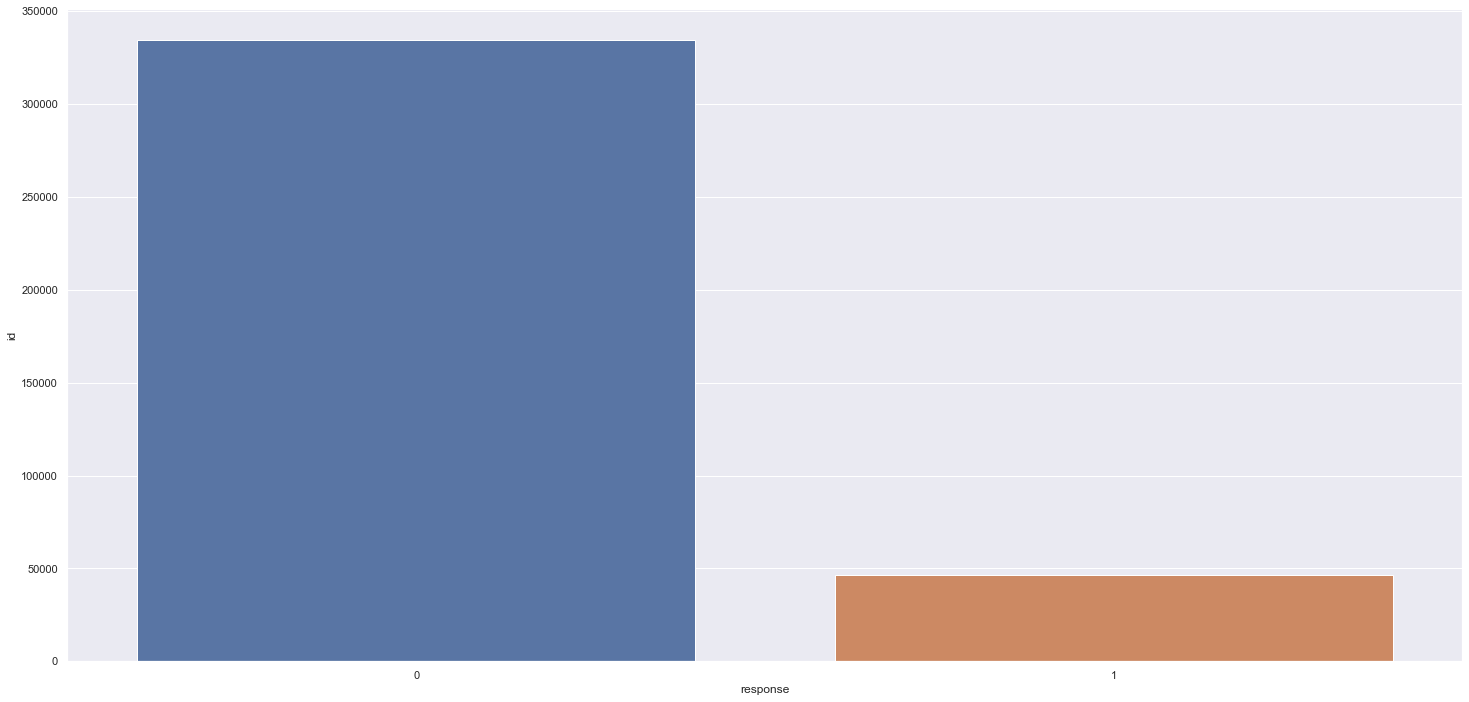

In [13]:
# Colocando em gráfico a variavel resposta
sns.barplot( data=df_response, x='response', y='id' );

# 2.0 FEATURE ENGINEERING

In [14]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

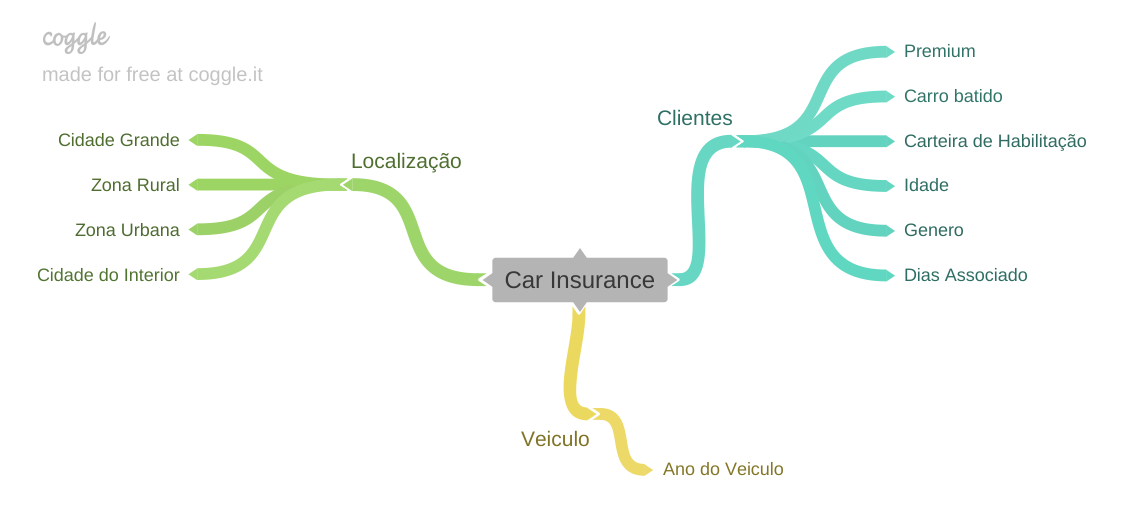

In [14]:
Image('C:/Users/Pedro/repos/health_insurance_cross_sell/pa004_health_insurance_cross_sell/health_insurance_cross-sell/img/car_insurance.png')

## 2.2 Criação das Hipóteses

### 2.2.1 Hipóteses de Clientes

**1.** 100% dos clientes sem carteira de habilitação não aderem ao seguro.

**2.** Clientes com mais dias associados tendem a aderir ao seguro.

**3.** 100% dos clientes que ja tiveram o carro batido aderem ao seguro.

**4.** Clientes mais velhos tendem a aderir ao seguro.

**5.** Mulheres tendem a aderir ao seguro 30% mais que homens.

### 2.2.1 Hipóteses de Localização

**1.** Clientes em zona rural aderem menos ao seguro.

**2.** Clientes em cidades grandes aderem mais ao seguro.

### 2.2.1 Hipóteses de Veiculo

**1.** Com veículo mais velho tendem a não aderir ao seguro.

**2.** 100% dos clientes que ja tem seguro de carro não aderem ao seguro.

## 2.3 Lista Final de Hipóteses

**1.** 100% dos clientes sem carteira de habilitação não aderem ao seguro.

**2.** Clientes com mais dias associados tendem a aderir ao seguro.

**3.** 100% dos clientes que ja tiveram o carro batido aderem ao seguro.

**4.** Clientes mais velhos tendem a aderir ao seguro.

**5.** Mulheres tendem a aderir ao seguro 30% mais que homens.

**6.** Clientes em zona rural aderem menos ao seguro.

**7.** Clientes em cidades grandes aderem mais ao seguro.

**8.** Com veículo mais velho tendem a não aderir ao seguro.

**9.** 100% dos clientes que ja tem seguro de carro não aderem ao seguro.

## 2.4 Feature Engineering

In [15]:
# vehicle_Age
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'below_1_year' if x == '< 1 Year' else 'between_1_2_year' if x == '1-2 Year' else 'over_2_years' )

# vehicle_damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

In [16]:
df2['vehicle_damage'].value_counts()

1    192413
0    188696
Name: vehicle_damage, dtype: int64

# 3.0 ANÁLISE EXPLORATÓRIA DOS DADOS

In [17]:
df3 = df2.copy()

## 3.1 Análise Univariada

### 3.1.1 Variavel Resposta

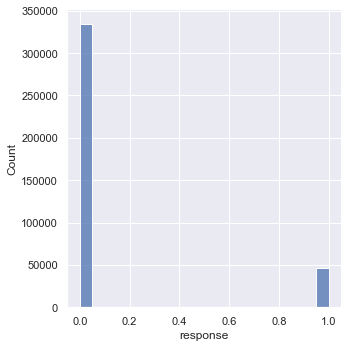

In [17]:
sns.displot( df3['response'] );

### 3.1.2 Varivavel Numérica

C:\Users\Pedro\AppData\Local\Temp/ipykernel_5692/3693512945.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_statistics['vehicle_damage'] = df3['vehicle_damage']


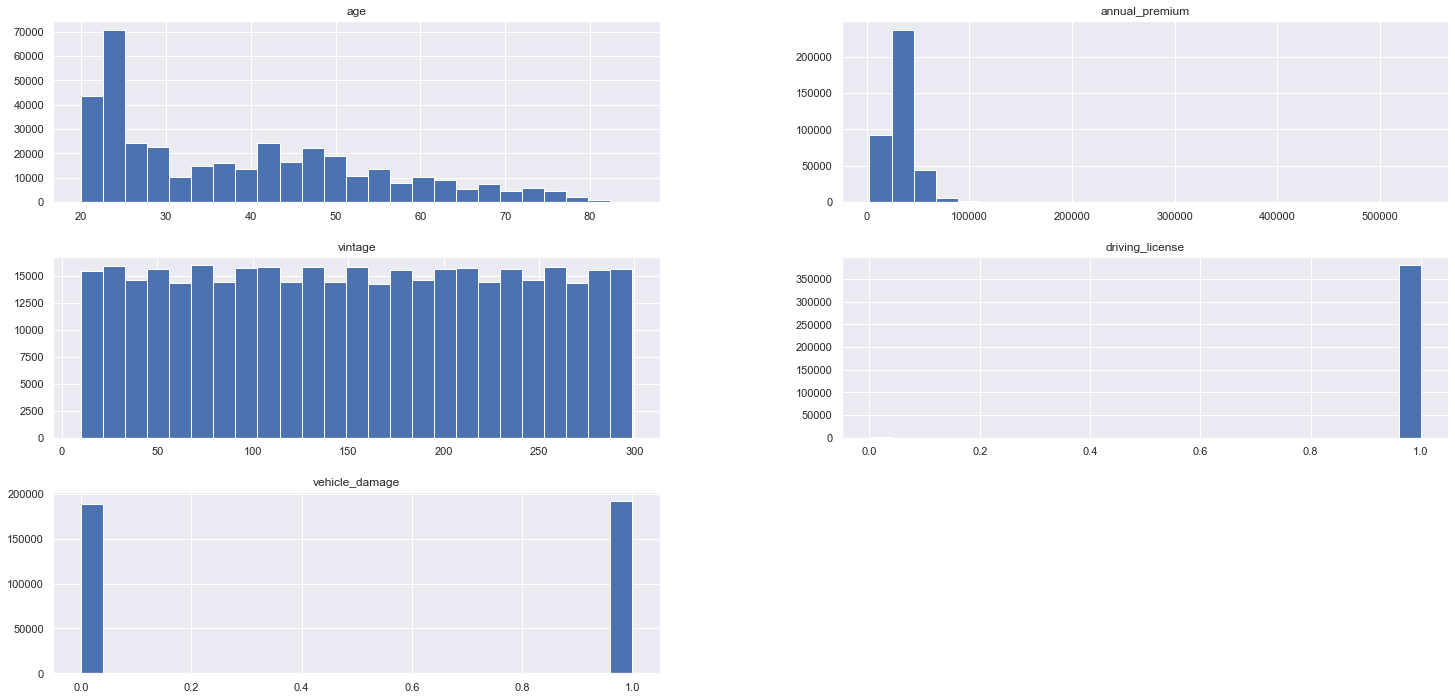

In [18]:
df_statistics['vehicle_damage'] = df3['vehicle_damage']
df_statistics.hist(bins=25);

### 3.1.3 Varivavel Categórica

In [19]:
cat_attributes = df3.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
cat_attributes.columns

Index(['gender', 'vehicle_age'], dtype='object')

C:\Users\Pedro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Pedro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


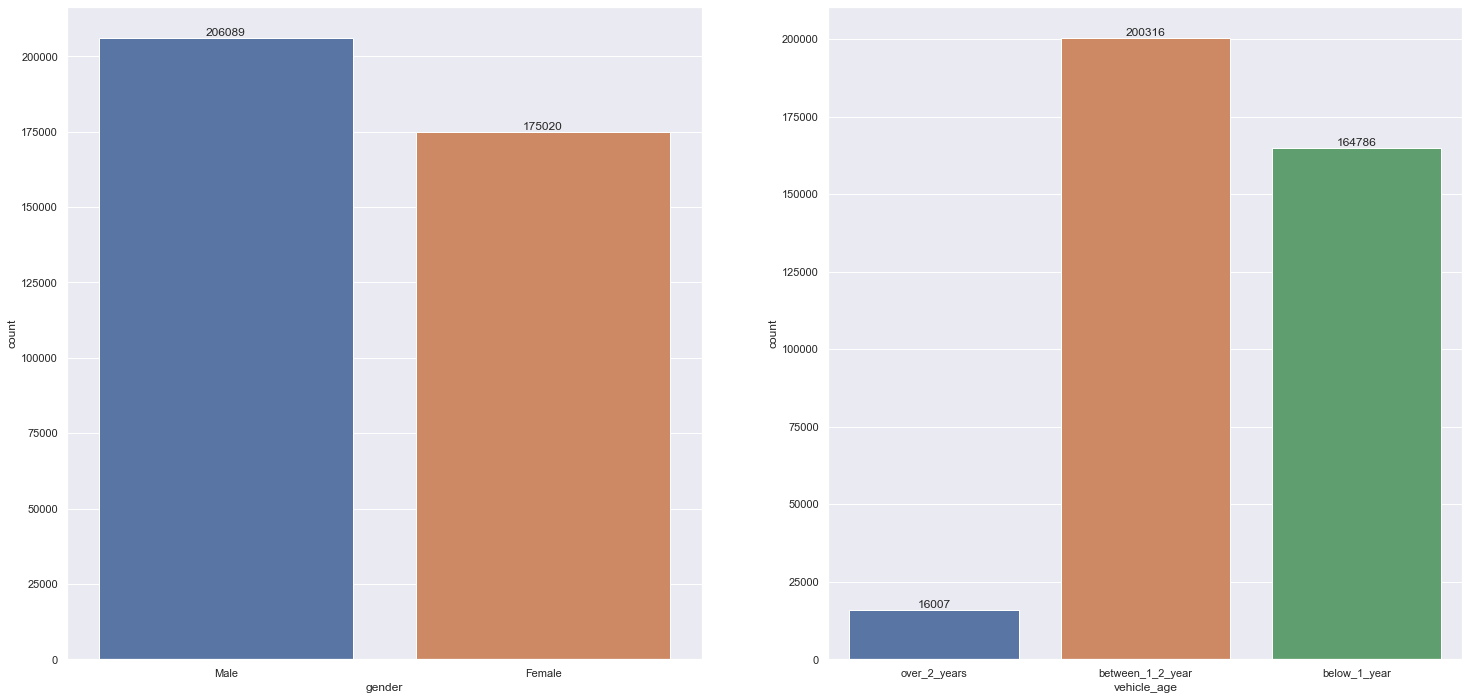

In [38]:
plt.subplot( 1, 2, 1 )
ax1 = sns.countplot( df3['gender'] );
for i in ax1.containers:
    ax1.bar_label(i,);
    
plt.subplot( 1, 2, 2 )
ax2 = sns.countplot( df3['vehicle_age'] );
for i in ax2.containers:
    ax2.bar_label(i,);

## 3.2 Análise Bivariada

### 1. 100% dos clientes sem carteira de habilitação não aderem ao seguro.
    FALSA. Das 812 pessoas que não possuem carteira de motorista, 41 aceitaram o seguro: 5,05%

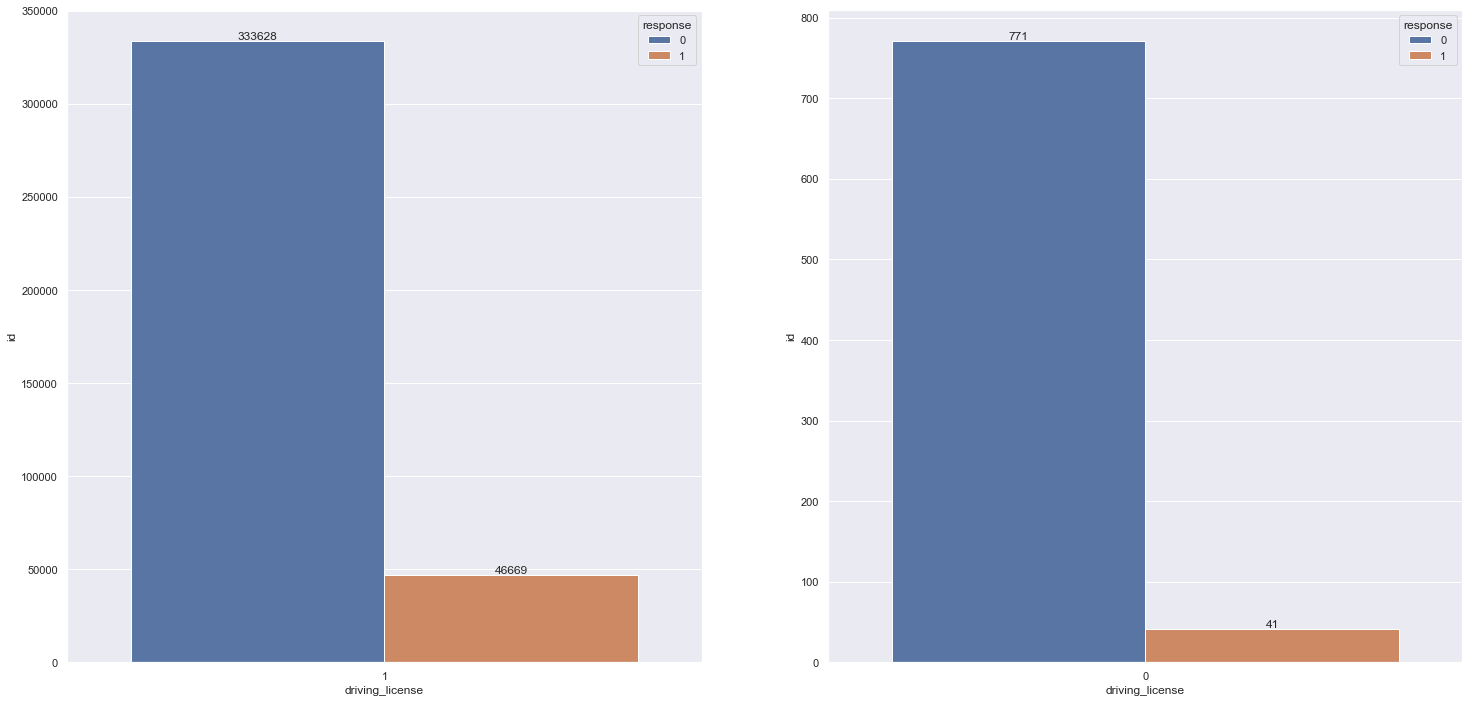

In [39]:
plt.subplot( 1, 2, 1 )
df3_aux1 = df3.loc[df3['driving_license']==1, :]
aux1 = df3_aux1[['driving_license', 'response', 'id']].groupby(['driving_license', 'response']).count().reset_index()
a = sns.barplot( data=aux1, x='driving_license', y='id', hue='response')
for i in a.containers:
    a.bar_label(i,);
    
plt.subplot( 1, 2, 2 )
df3_aux2 = df3.loc[df3['driving_license']==0, :]
aux1 = df3_aux2[['driving_license', 'response', 'id']].groupby(['driving_license', 'response']).count().reset_index()
b = sns.barplot( data=aux1, x='driving_license', y='id', hue='response')
for i in b.containers:
    b.bar_label(i,);

### 2. Clientes com mais dias associados tendem a aderir ao seguro.
    Falsa - Na média ambos que aceitaram ou recusaram tem a mesma quantidade de dias associados

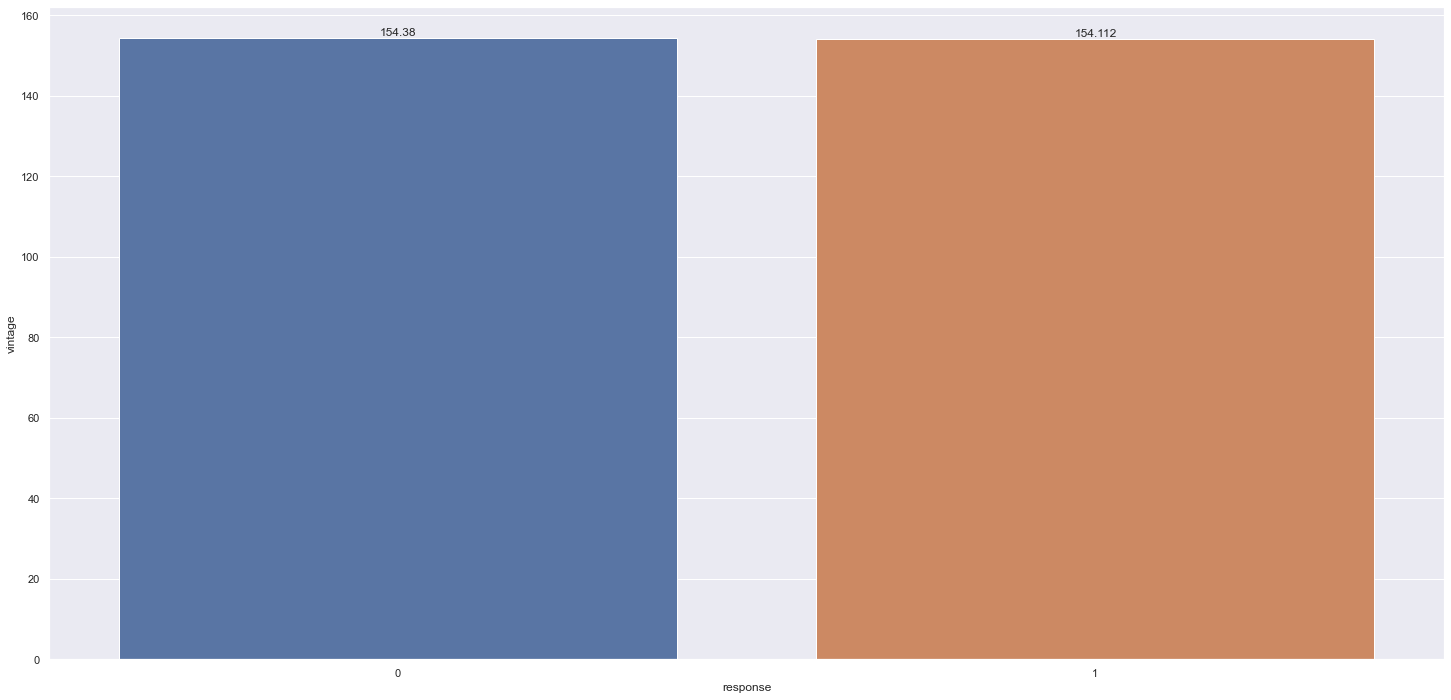

In [40]:
aux1 = df3[['vintage', 'response']].groupby('response').mean().reset_index()
a = sns.barplot( data=aux1, x='response', y='vintage');
for i in a.containers:
    a.bar_label(i,);

### **3.** 100% dos clientes que ja tiveram o carro batido aderem ao seguro.
    Falsa - Das pessoas que ja bateram o carro 76,23% recusaram o seguro.

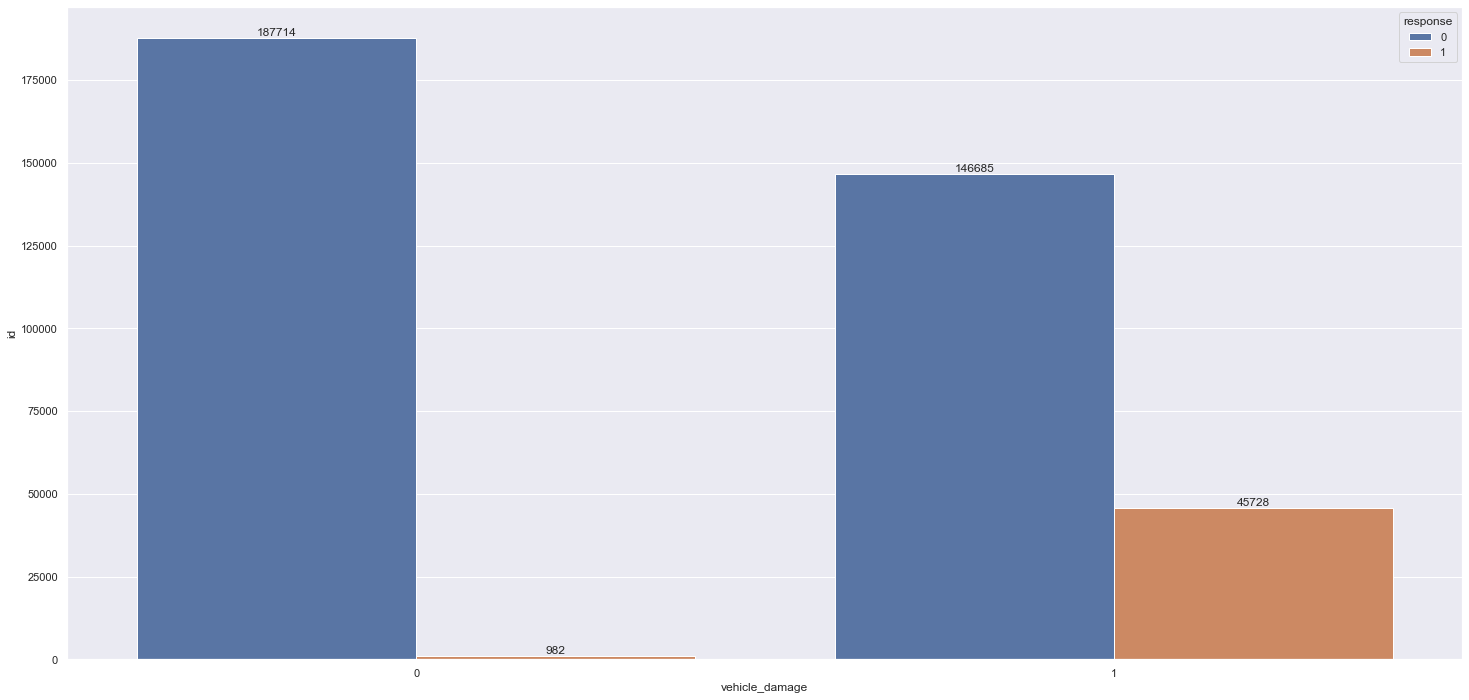

In [41]:
aux1 = df3[['vehicle_damage', 'response', 'id']].groupby(['response', 'vehicle_damage']).count().reset_index()
a = sns.barplot( data=aux1, x='vehicle_damage', y='id', hue='response');
for i in a.containers:
    a.bar_label(i,);

### **4.** Clientes mais velhos tendem a aderir ao seguro.
    Verdadeiro - Na média, clientes que aceitam o seguro são mais velhos.

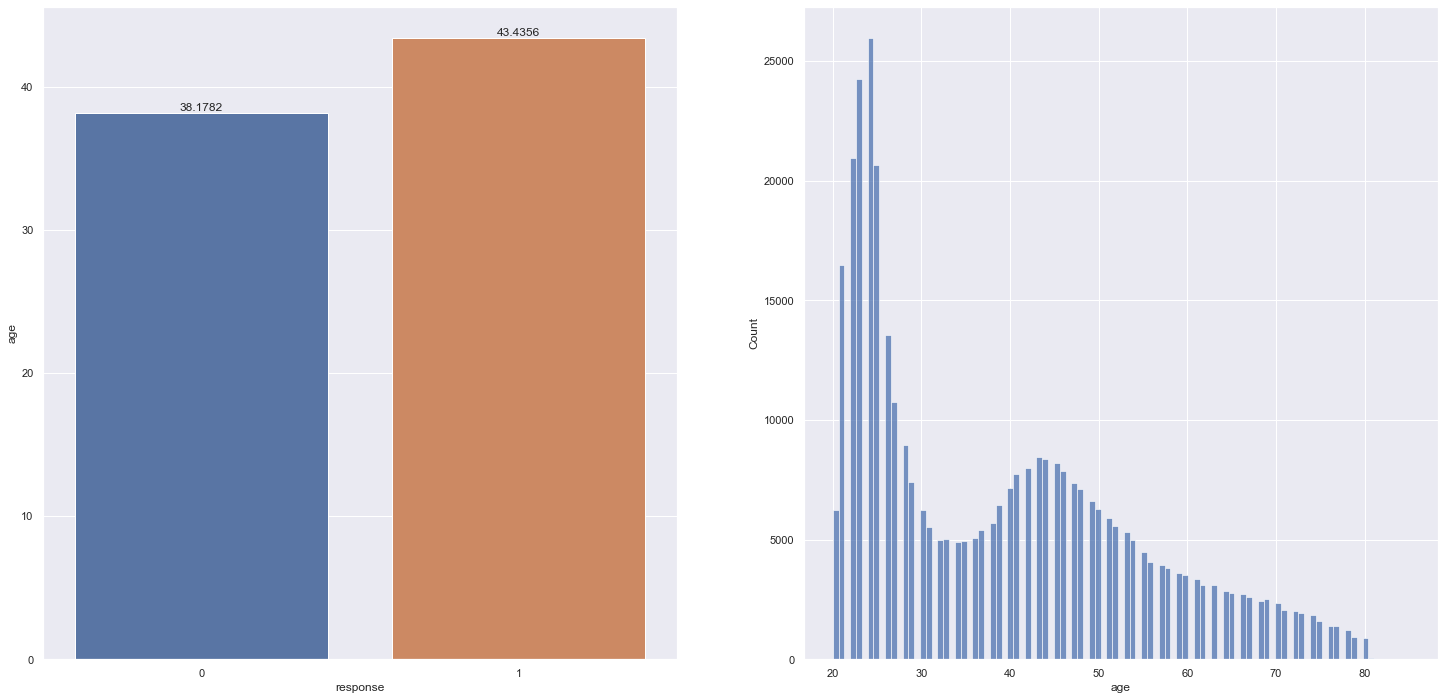

In [42]:
plt.subplot(1, 2, 1)
aux1 = df3[['age', 'response']].groupby('response').mean().reset_index()
a = sns.barplot( data=aux1, x= 'response', y='age');
for i in a.containers:
    a.bar_label(i,);
    
plt.subplot(1, 2, 2)
sns.histplot( df3['age'] );

### **5.** Mulheres tendem a aderir ao seguro 30% mais que homens.
    Falsa - Apenas 10,39% das mulheres aceitaram o seguro. Enquanto 13,84% dos homens aceitaram.

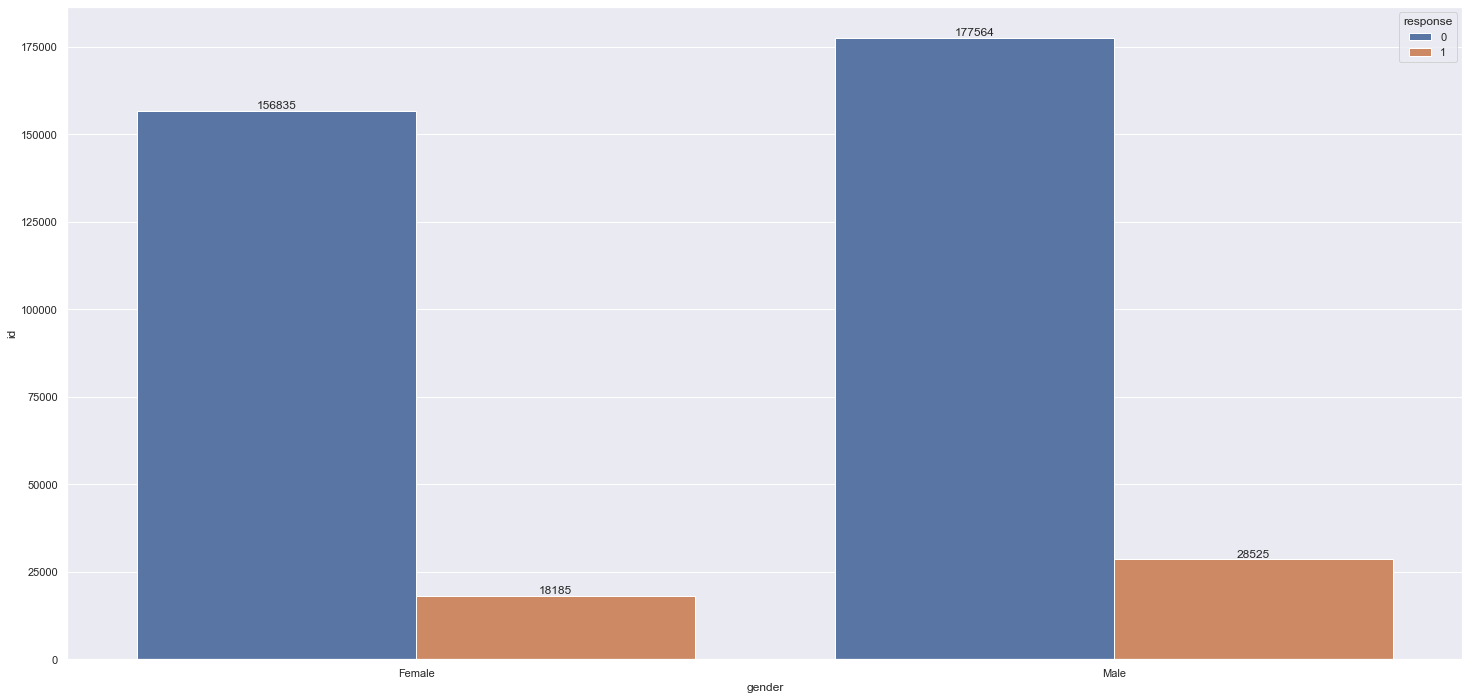

In [43]:

aux1 = df3[['gender', 'response', 'id']].groupby(['response', 'gender']).count().reset_index()
a = sns.barplot( data=aux1, x= 'gender', y='id', hue='response');
for i in a.containers:
    a.bar_label(i,);

### **6.** Clientes em zona rural aderem menos ao seguro.

### **7.** Clientes em cidades grandes aderem mais ao seguro.

### **8.** Clientes com veículo mais velho tendem a não aderir ao seguro.
    Falsa - A maior taxa de conversão são os que tem o carro > 2 anos, com 29,37%. Seguido dos carros entre 1-2 anos com 17,38%.

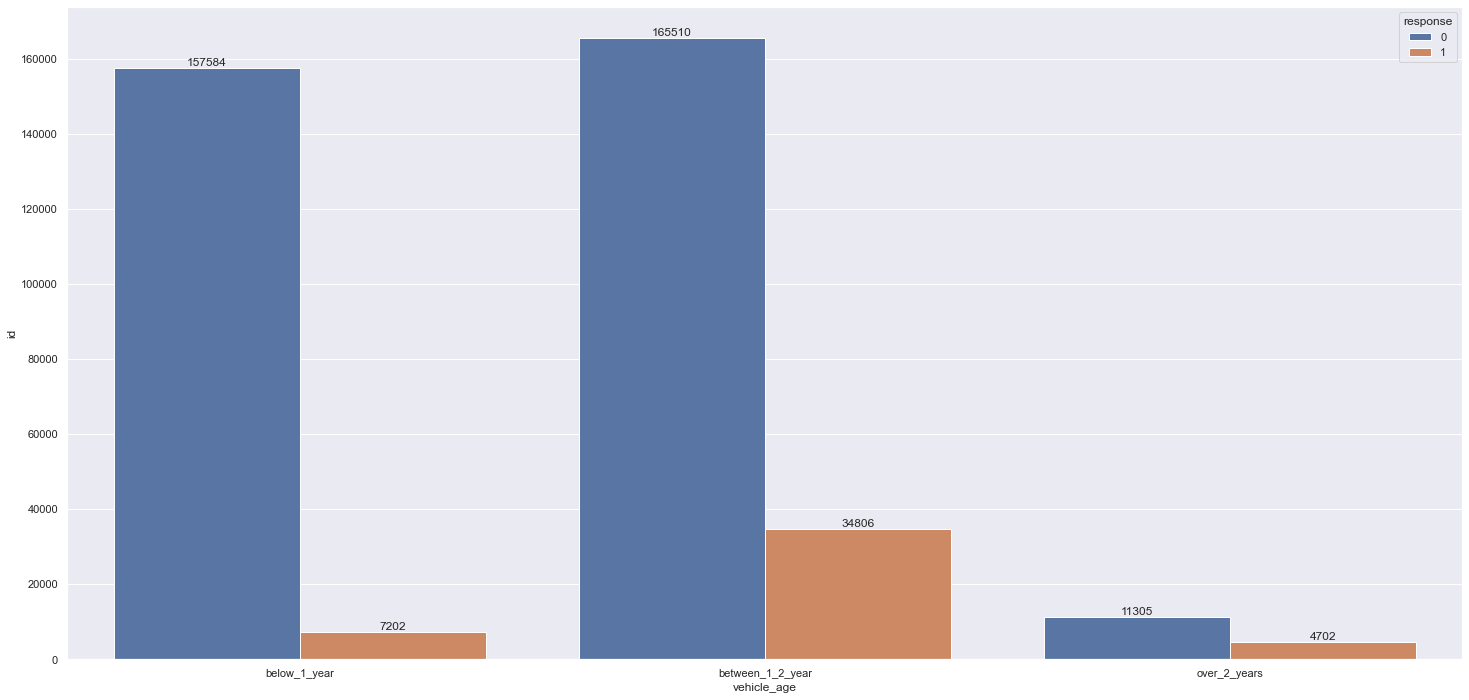

In [44]:
aux1 = df3[['vehicle_age', 'response', 'id']].groupby(['response', 'vehicle_age']).count().reset_index()
a = sns.barplot( data=aux1, x='vehicle_age', y='id', hue='response');
for i in a.containers:
    a.bar_label(i,);

### **9.** 100% dos clientes que ja tem seguro de carro não aderem ao seguro.
    Falsa - 99,91% dos que ja possuem seguro não aderem ao novo seguro.

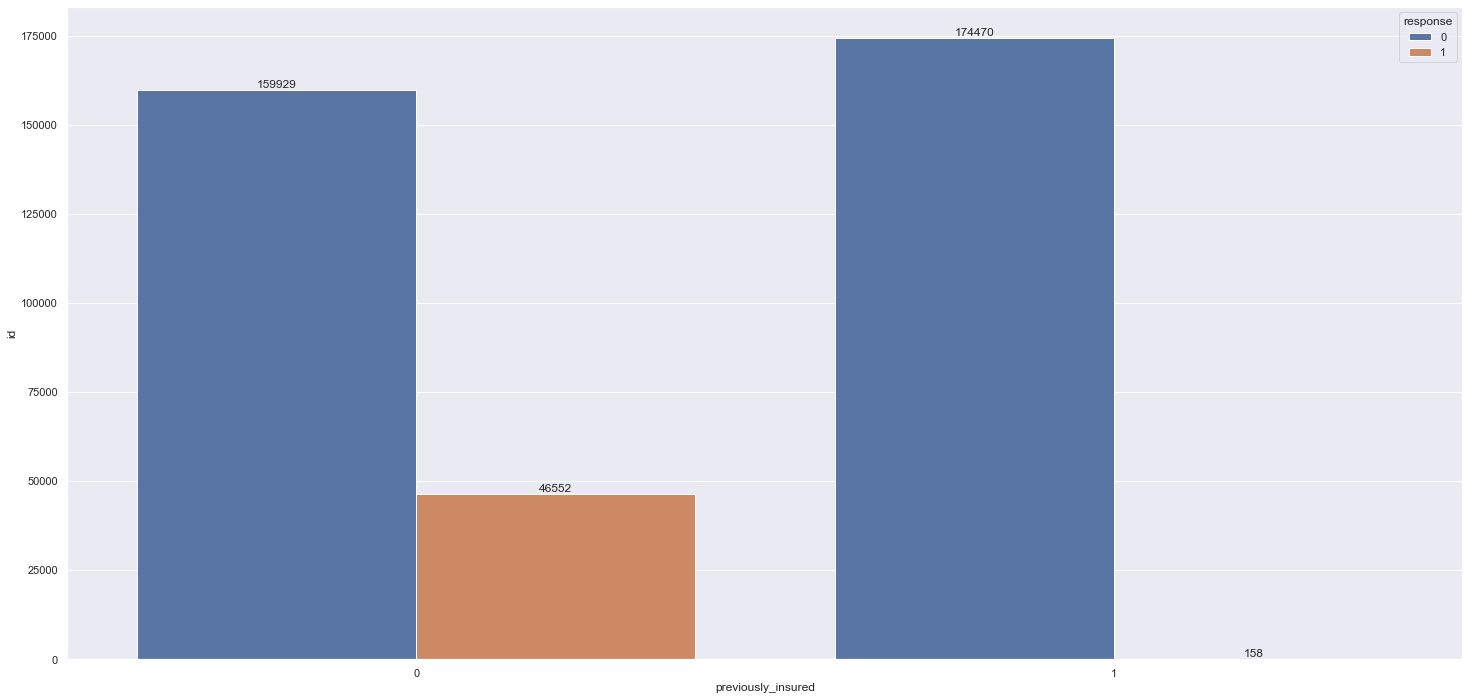

In [45]:
aux1 = df3[['previously_insured', 'response', 'id']].groupby(['response', 'previously_insured']).count().reset_index()
a = sns.barplot( data=aux1, x='previously_insured', y='id', hue='response');
for i in a.containers:
    a.bar_label(i,);

## 3.1 Análise Multivariada

### 3.1.1 Numerical Attributes

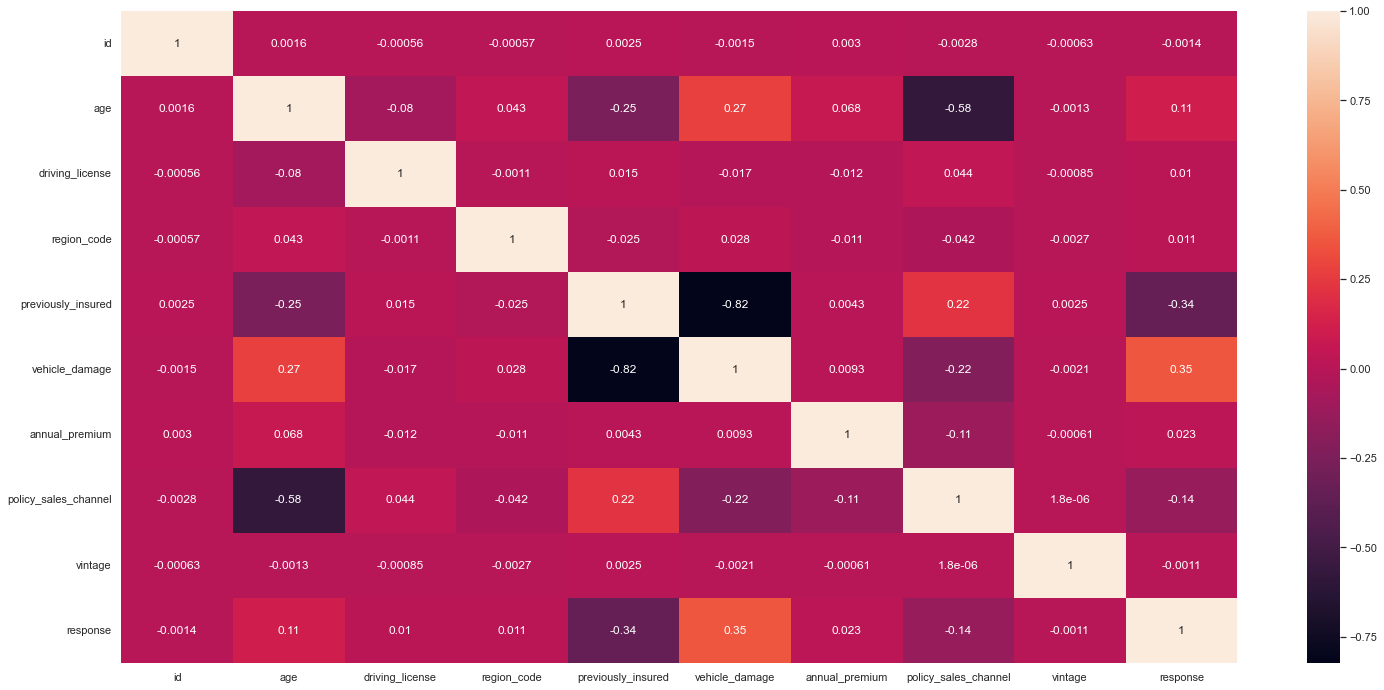

In [20]:
num_atributes = df3.select_dtypes( include=['int64', 'float64'] )
correlation = num_atributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 3.1.1 Categorical Attributes

In [21]:
# only categorical data
a = df3.select_dtypes( include='object' )
a.columns

Index(['gender', 'vehicle_age'], dtype='object')

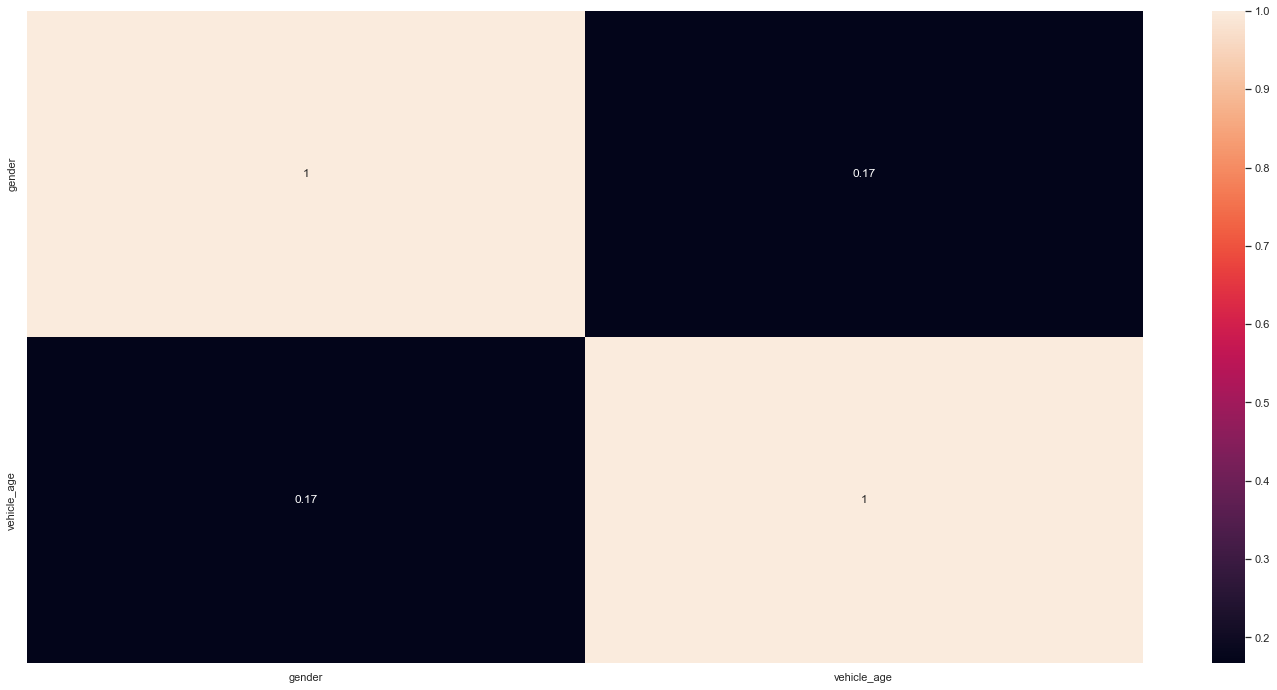

In [22]:
# Calculate cramer V
a1 = cramer_v( a['gender'], a['gender'] )
a2 = cramer_v( a['gender'], a['vehicle_age'] )
a4 = cramer_v( a['vehicle_age'], a['gender'] )
a5 = cramer_v( a['vehicle_age'], a['vehicle_age'] )

# Final dataset
d = pd.DataFrame( {'gender': [a1, a2],
                    'vehicle_age': [a4, a5] } )
d = d.set_index( d.columns )
sns.heatmap( d, annot=True );

# 4.0 DATA PREPARATION

In [18]:
df4= df3.copy()

In [19]:
X = df3.drop('response', axis=1)
y = df3['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.20 )

df4 = pd.concat( [ x_train, y_train ], axis = 1 )

## Stardadization

In [20]:
ss = pp.StandardScaler()

# Annual Premium
df4['annual_premium'] = ss.fit_transform( df4[['annual_premium']].values )
pickle.dump( ss, open( 'C:/Users/Pedro/repos/health_insurance_cross_sell/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/features/annual_premium_scaler.pkl', 'wb' ) )

## Rescaling

In [21]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age
df4['age'] = mms_age.fit_transform( df4[['age']].values )
pickle.dump( mms_age, open('C:/Users/Pedro/repos/health_insurance_cross_sell/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/features/age_scaler.pkl', 'wb' ) )

# Vintage
df4['vintage'] = mms_vintage.fit_transform( df4[['vintage']].values )
pickle.dump( mms_vintage, open('C:/Users/Pedro/repos/health_insurance_cross_sell/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/features/vintage_scaler.pkl', 'wb') )

## Encoder

In [22]:
# Gender - Target Encoding
target_encoding_gender = df4.groupby('gender')['response'].mean()
df4.loc[:, 'gender'] = df4['gender'].map( target_encoding_gender )
pickle.dump(target_encoding_gender, open('C:/Users/Pedro/repos/health_insurance_cross_sell/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/features/target_encode_gender_scaler.pkl', 'wb'  )  )

# Region Code - Target Encoding
target_encoding_region_code = df4.groupby('region_code')['response'].mean() 
df4.loc[:, 'region_code'] = df4['region_code'].map( target_encoding_region_code )
pickle.dump(target_encoding_region_code, open('C:/Users/Pedro/repos/health_insurance_cross_sell/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/features/target_encode_region_code_scaler.pkl', 'wb' ) )
 
# Vehicle Age - One Hot Encoding
df4 = pd.get_dummies( df4, prefix='vehicle_age', columns=['vehicle_age'] )

# Policy Sales Channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df4.groupby('policy_sales_channel').size() / len( df4 )
df4.loc[:, 'policy_sales_channel'] = df4['policy_sales_channel'].map( fe_policy_sales_channel )
pickle.dump(fe_policy_sales_channel, open('C:/Users/Pedro/repos/health_insurance_cross_sell/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/features/fe_policy_sales_channel_scaler.pkl', 'wb'))

## 4.1 Validation Preparation

In [23]:
# Gender
x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map( target_encoding_gender )

# Age
x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values )

# Region Code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map( target_encoding_region_code )

# Vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values )

# Annual Premium
x_validation.loc[:, 'annual_premium'] = ss.transform( x_validation[['annual_premium']].values )

# Vehicle Age
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )

# Policy Sales Channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# fill NA - Conferir se tinha NA
x_validation = x_validation.fillna( 0 )

C:\Users\Pedro\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\Pedro\anaconda3\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\Pedro\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

# 5.0 FEATURE SELECTION

## 5.1 Features Importance

In [24]:
# Model Definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# Data Preparation
x_train_n = df4.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

In [25]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print Feature Ranking
print('Feature Importance:')
df = pd.DataFrame()
for i, j in zip( x_train_n, importances ):
    aux = pd.DataFrame( {'feature':i, 'importance':j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print(df.sort_values('importance', ascending=False))

Feature Importance:
                        feature  importance
0                       vintage    0.272808
0                annual_premium    0.245427
0                           age    0.163427
0                   region_code    0.106620
0                vehicle_damage    0.068511
0          policy_sales_channel    0.059730
0            previously_insured    0.055662
0      vehicle_age_below_1_year    0.014107
0  vehicle_age_between_1_2_year    0.006162
0                        gender    0.004969
0      vehicle_age_over_2_years    0.002103
0               driving_license    0.000476


# 6.0 MACHINE LEARNING

In [26]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']

x_train = df4[cols_selected]
x_val = x_validation[cols_selected]
y_val = y_validation.copy()

## 6.1 KNN

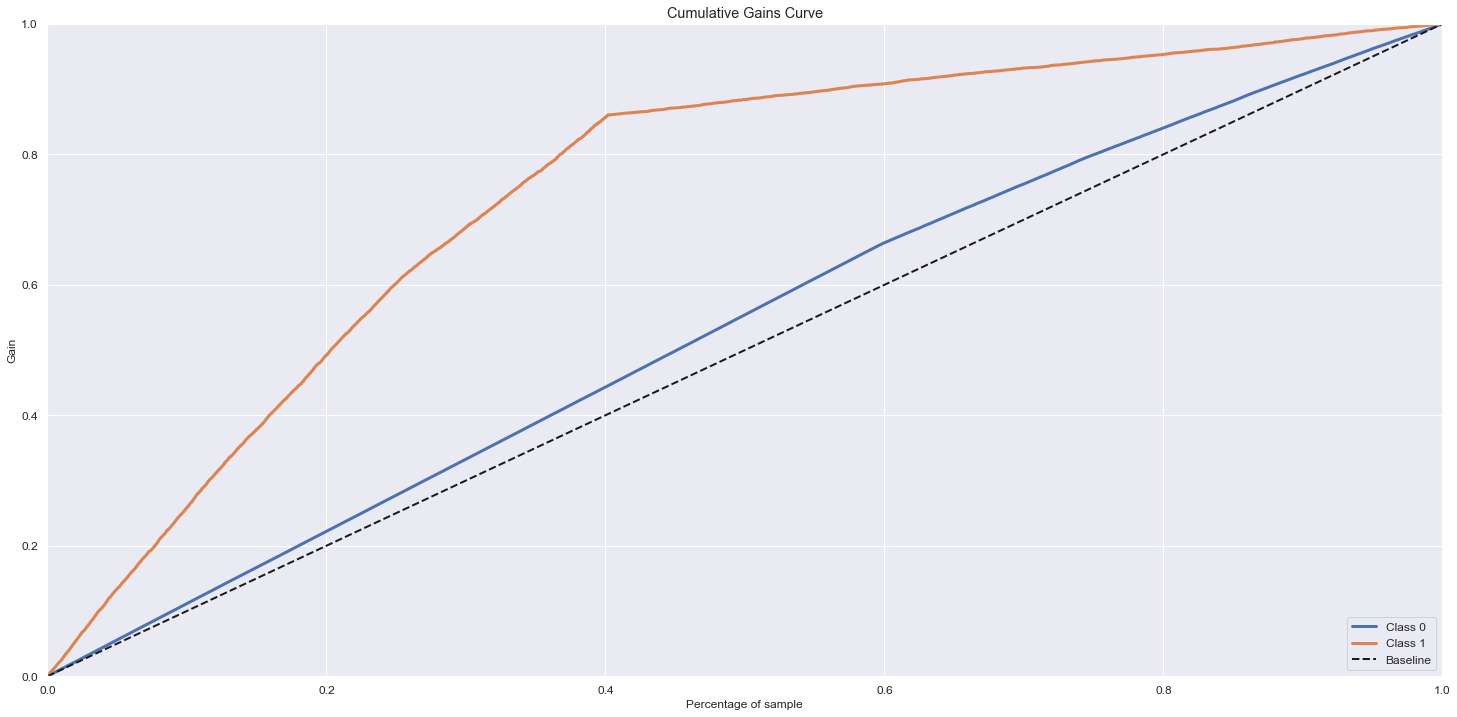

In [27]:
# Model Definition
knn_model = nh.KNeighborsClassifier( n_neighbors=7 )

# Model Training
knn_model.fit( x_train, y_train )

# Model Prediction - Poder de Generalização
yhat_knn = knn_model.predict_proba( x_val )

# Acumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn );

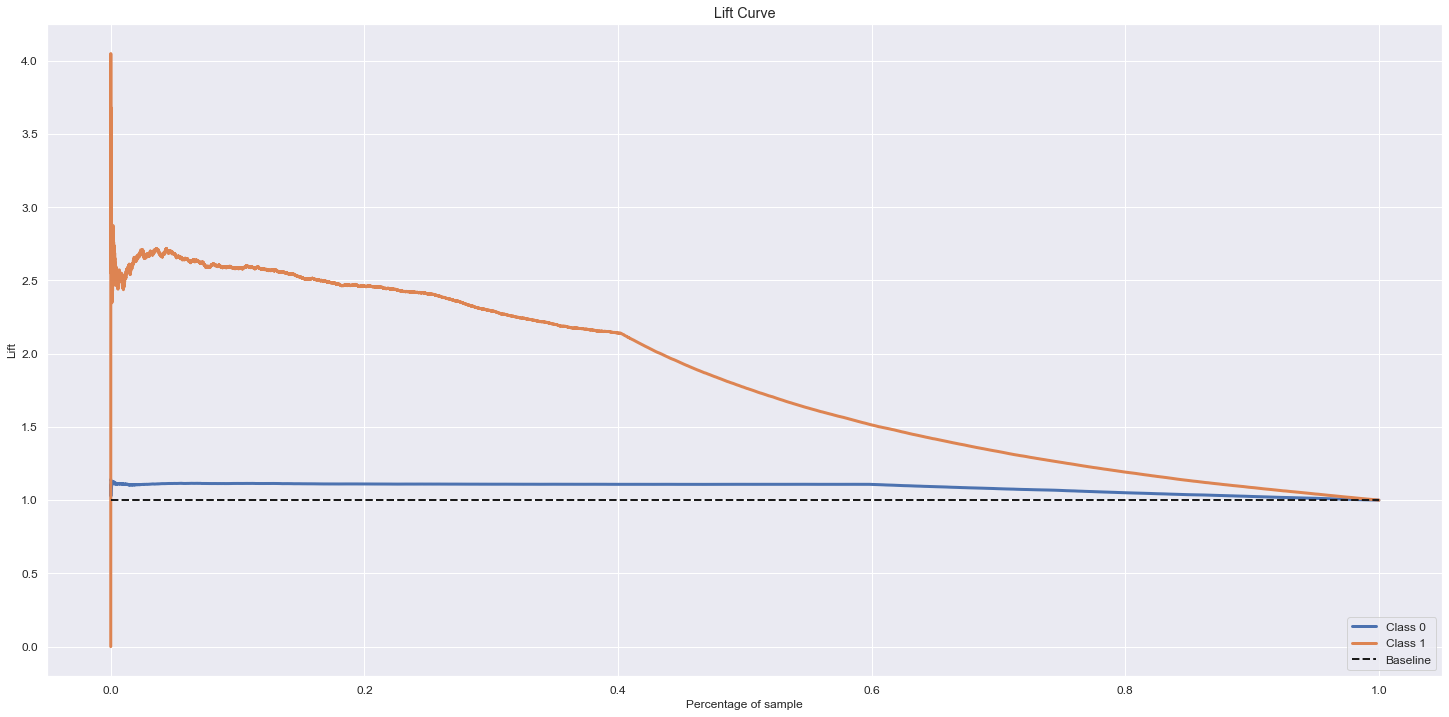

In [28]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_knn );

## 6.2 Logistic Regression

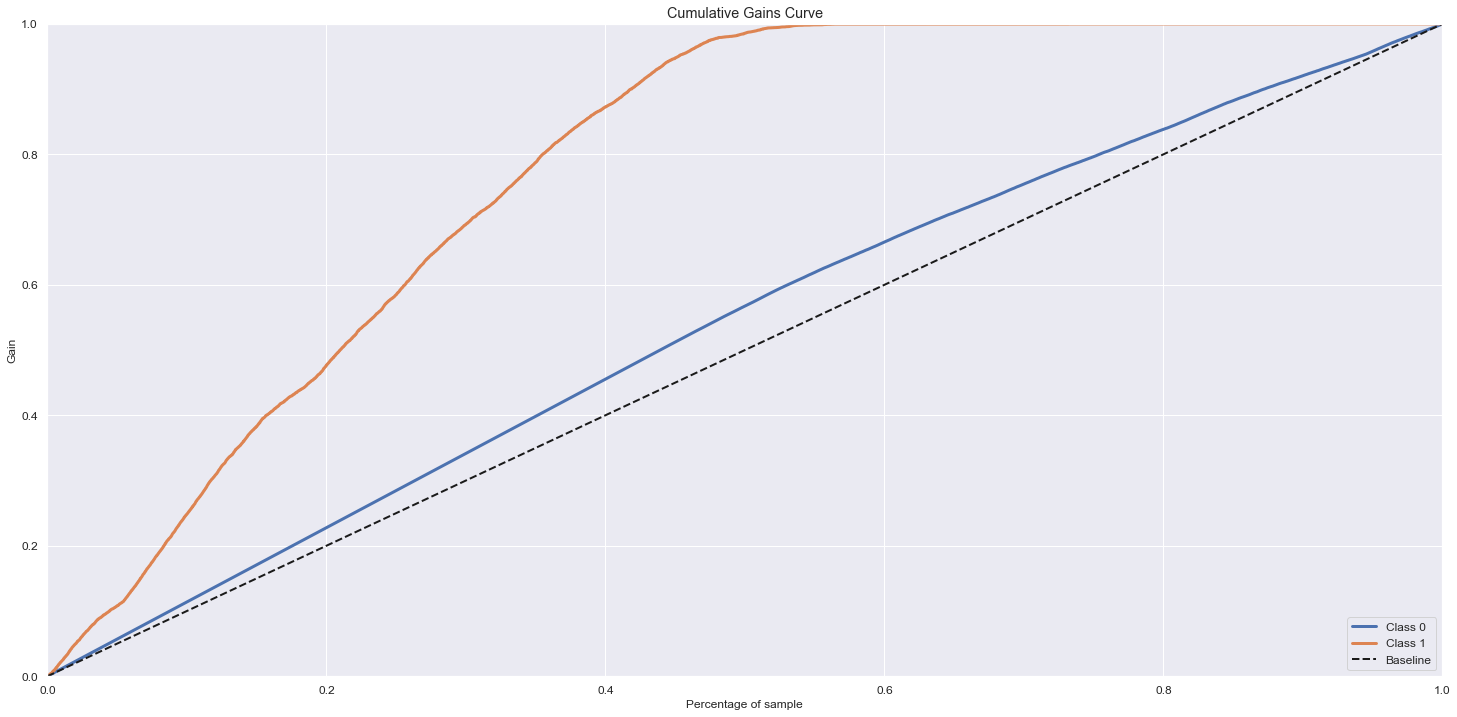

In [50]:
# Model Definition
lr_model = lm.LogisticRegression( random_state=42 )

# Model Training
lr_model.fit( x_train, y_train )

# Model Prediction
yhat_lr = lr_model.predict_proba( x_val )

# Acumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

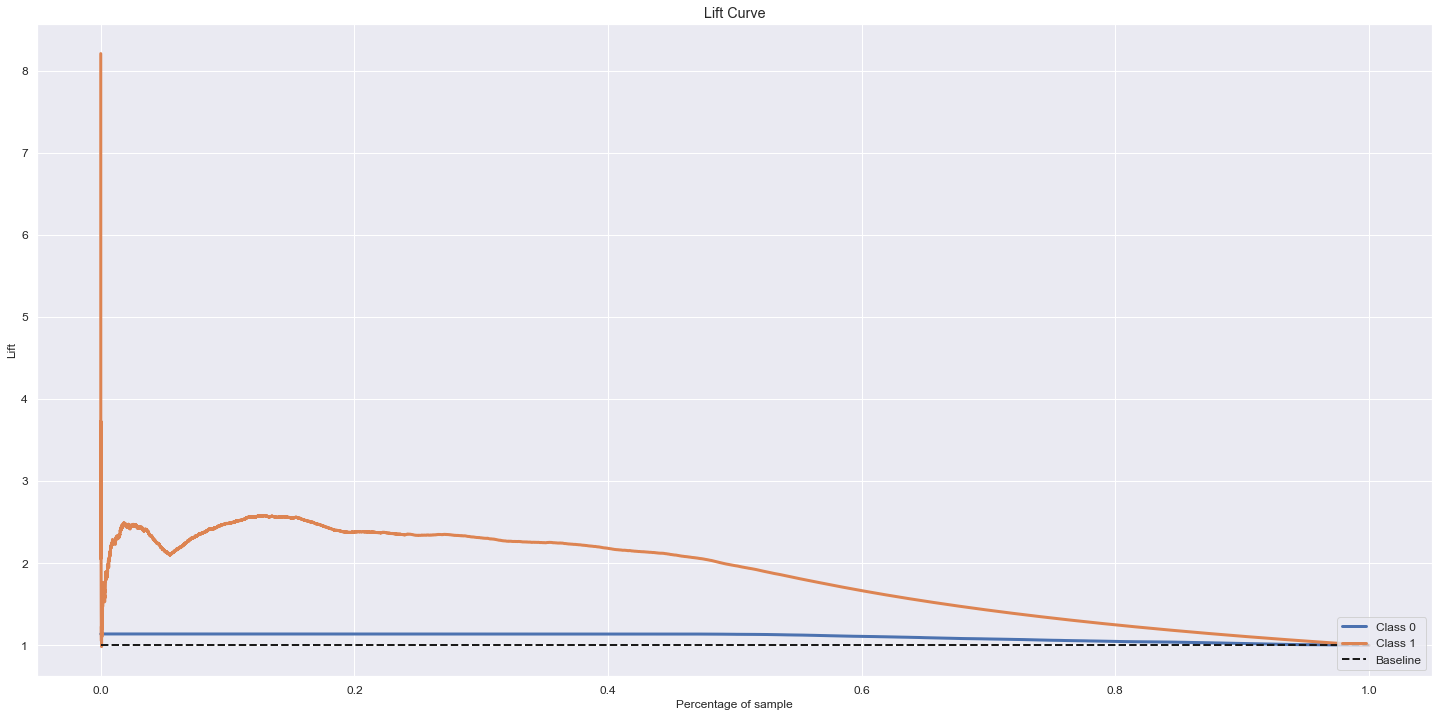

In [51]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_lr );

## 6.3 Extra Trees

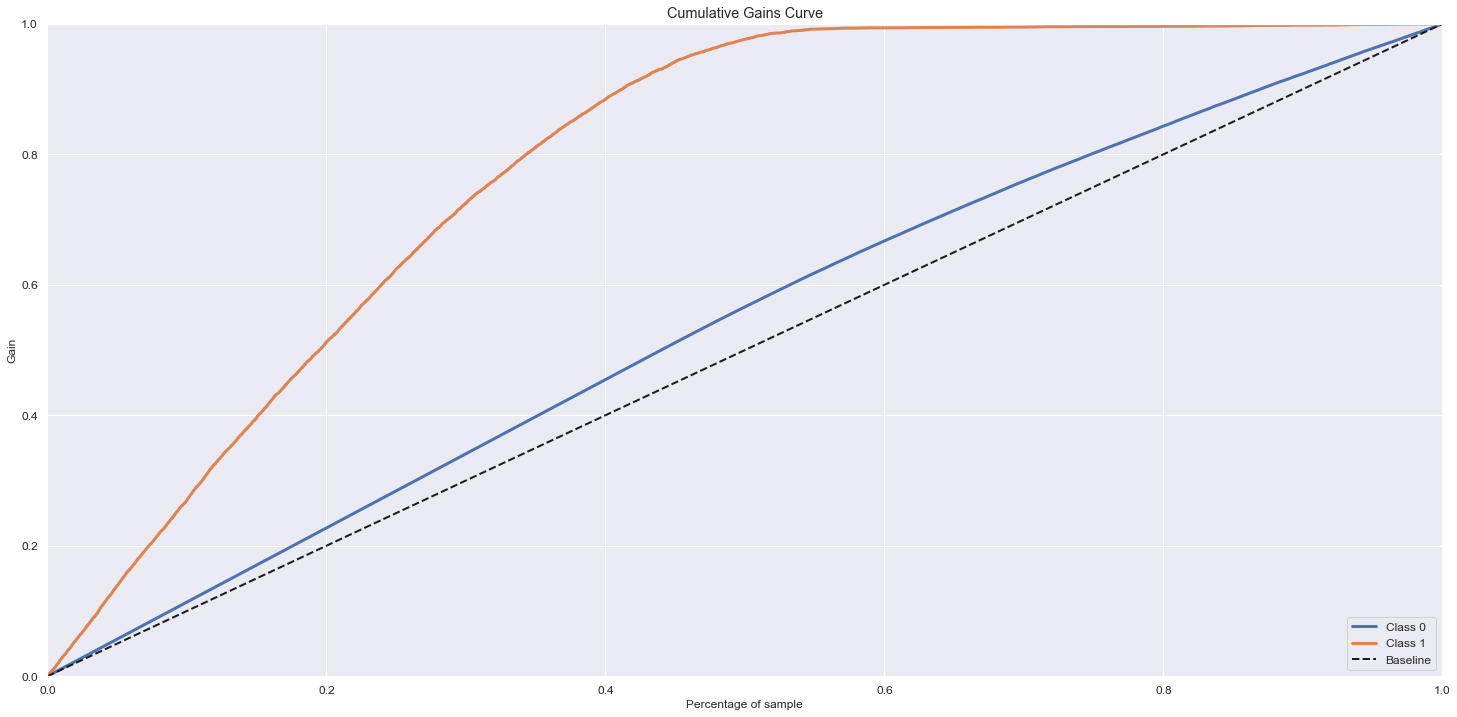

In [52]:
# Model Definition
et_model = en.ExtraTreesClassifier( n_estimators=1000, n_jobs=-1, random_state=42 )

# Model Training
et_model.fit( x_train, y_train )

# Model Prediction - Poder de Generalização
yhat_et = et_model.predict_proba( x_val )

# Acumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_et );

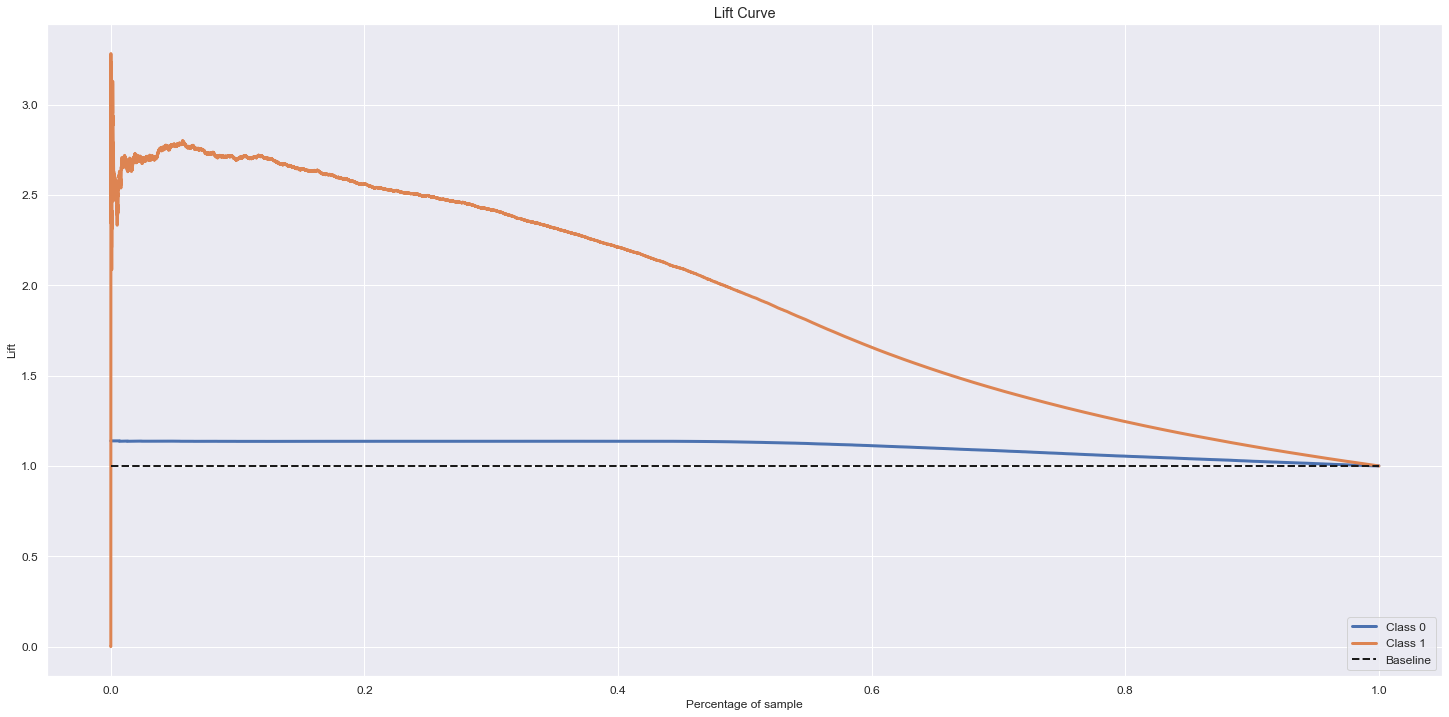

In [53]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_et );

## 6.4 Random Forest

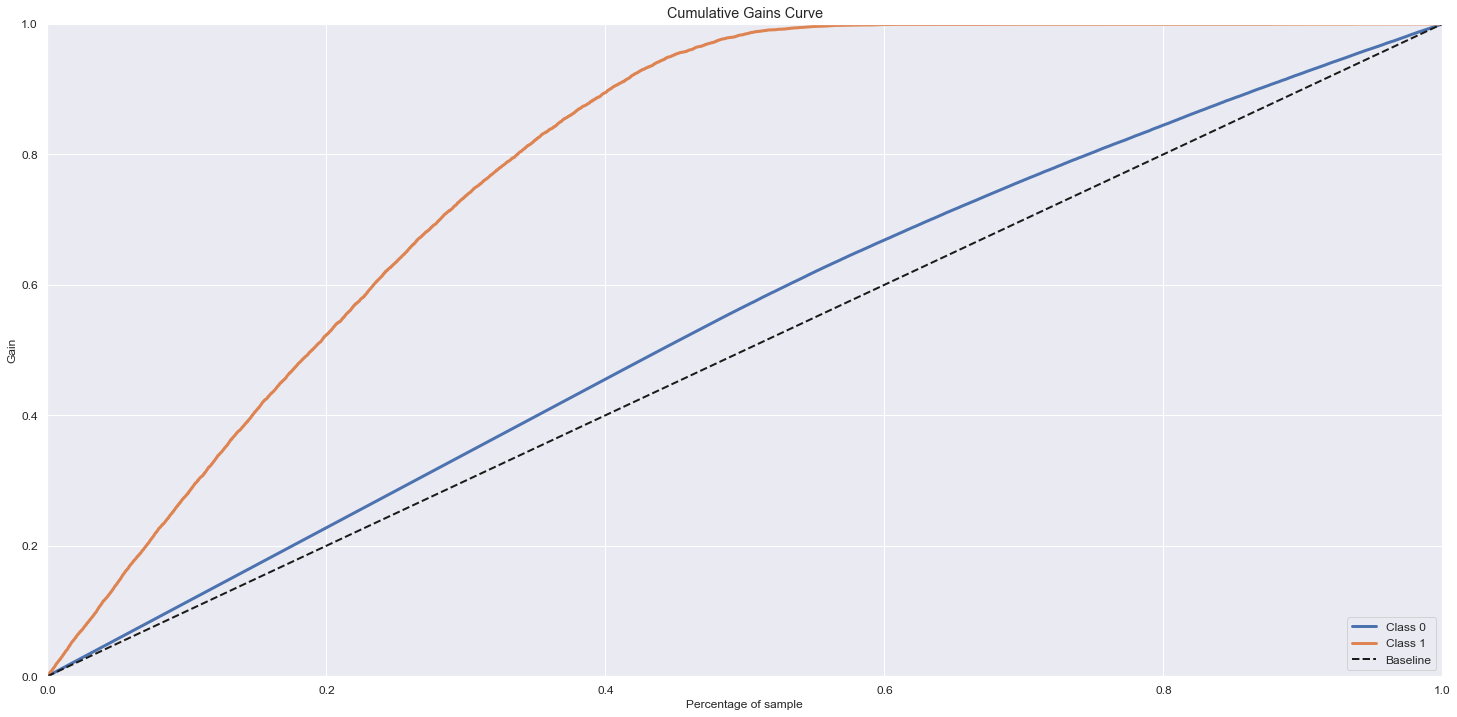

In [54]:
# model definition
rf = en.RandomForestClassifier( n_estimators=1000, n_jobs=-1, random_state=42 ) 

# model training
rf.fit( x_train, y_train )

# model prediction
yhat_rf = rf.predict_proba( x_val )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_rf );

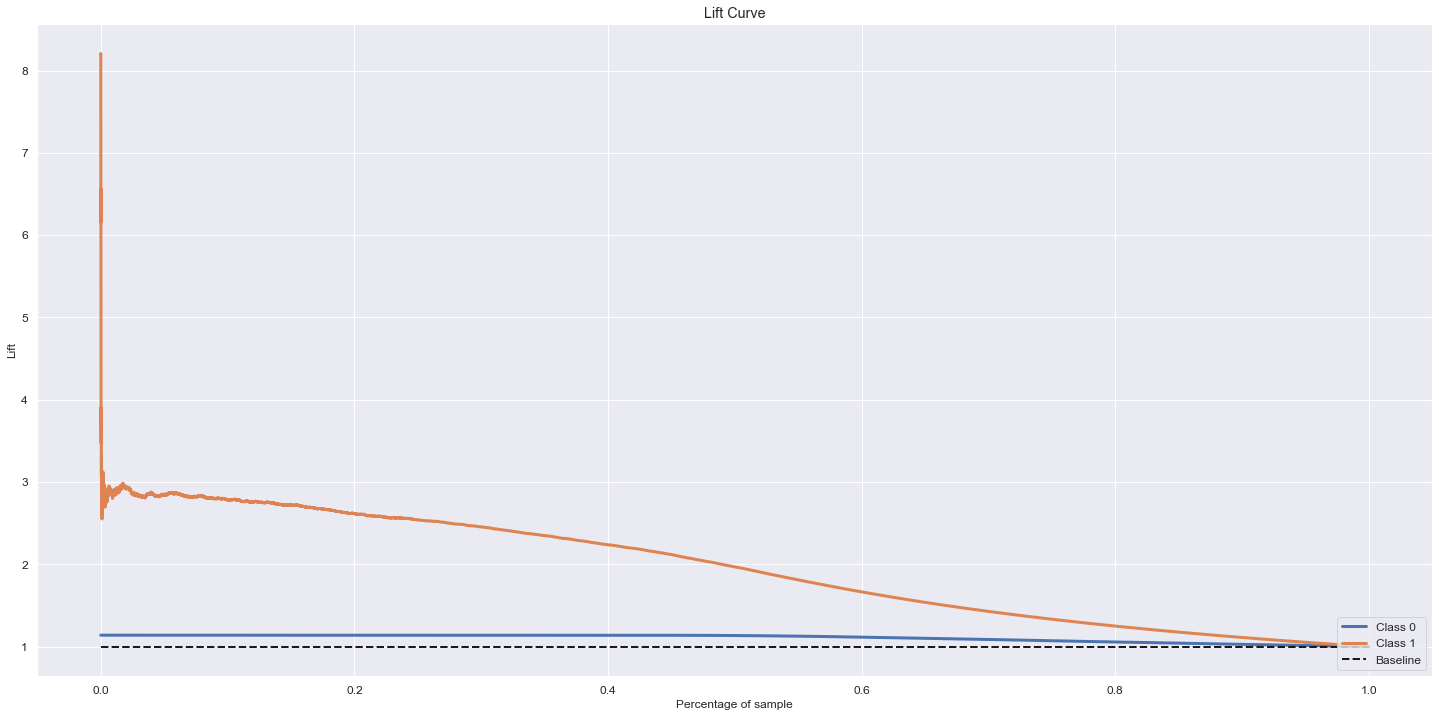

In [55]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_rf );

# 7.0 MODEL PERFORMANCE

In [29]:
def precision_at_k( data, k=2000 ):
    
    # Reset Index
    data = data.reset_index(drop=True)

    # Create ranking order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    data[['ranking', 'id', 'response', 'score', 'precision_at_k']].head()
    
    return data.loc[k, 'precision_at_k']

In [30]:
def recall_at_k( data, k=2000 ):
    
    # Reset Index
    data = data.reset_index(drop=True)

    # Create ranking order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    data[['ranking', 'id', 'response', 'score', 'recall_at_k']].head()
    
    return data.loc[k, 'recall_at_k']

In [31]:
df7 = x_validation.copy()
df7['response'] = y_validation.copy()

# Propensity Score
df7['score'] = yhat_knn[:, 1].tolist()

# Sort clients by propensity score
df7 = df7.sort_values( 'score', ascending=False )

# Compute precision at K
precision_at_50 = precision_at_k( df7, k=50 )
print('Precision At K: {}'.format( precision_at_50 ) )

# Recall at K
recall_at_50 = recall_at_k( df7, k=50 )
print('Recall At K: {}'.format( recall_at_50 ) )

Precision At K: 0.3137254901960784
Recall At K: 0.0016999575010624734


# 8.0 DEPLOY TO PRODUCTION     

In [33]:
pickle.dump( knn_model, open('C:/Users/Pedro/repos/health_insurance_cross_sell/pa004_health_insurance_cross_sell/health_insurance_cross-sell/src/models/model_knn.pkl', 'wb') )

# 8.1 Health Insurance Class

In [42]:
class HealthInsurance:

    def __init__( self ):  
        self.homepath = 'C:/Users/Pedro/repos/health_insurance_cross_sell/pa004_health_insurance_cross_sell/health_insurance_cross-sell'
        self.age_scaler                  = pickle.load( open(self.homepath + '/src/models/age_scaler.pkl') )
        self.annual_premium_scaler       = pickle.load( open(self.homepath + '/src/models/annual_premium_scaler.pkl') )
        self.policy_sales_channel_scaler = pickle.load( open(self.homepath + '/src/models/fe_policy_sales_channel_scaler.pkl') )
        self.gender_scaler               = pickle.load( open(self.homepath + '/src/models/target_encode_gender_scaler.pkl') )
        self.region_code_scaler          = pickle.load( open(self.homepath + '/src/models/target_encode_region_code_scaler.pkl') )
        self.vintage_scaler              = pickle.load( open(self.homepath + '/src/models/vintage_scaler.pkl') )
        
        
        
    def data_cleaning(self, data):
        
        cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code',
                    'previously_insured', 'vehicle_age', 'vehicle_damage', 
                    'annual_premium', 'policy_sales_channel', 'vintage', 'response']

        data.columns = cols_new
        
        return data
    
    
    def feature_engineering(self, data):
        
        # vehicle_Age
        data['vehicle_age'] = data['vehicle_age'].apply( lambda x: 'below_1_year' if x == '< 1 Year' else 'between_1_2_year' if x == '1-2 Year' else 'over_2_years' )

        # vehicle_damage
        data['vehicle_damage'] = data['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )
        
        return data
    
    
    def data_preparation(self, data):
        
        # Annual Premium
        data['annual_premium'] = self.annual_premium_scaler.transform( data[['annual_premium']].values )
        
        # Age
        data['age'] = self.age_scaler.transform( data[['age']].values )
        
        # Vintage
        data['vintage'] = self.vintage_scaler.transform( data[['vintage']].values )
        
        # Gender 
        data.loc[:, 'gender'] = data['gender'].map( self.gender_scaler )
        
        # Region Code 
        data.loc[:, 'region_code'] = data['region_code'].map( self.region_code_scaler )
        
        # Vehicle Age 
        data = pd.get_dummies( data, prefix='vehicle_age', columns=['vehicle_age'] )
        
        # Policy Sales Channel - Target Encoding / Frequency Encoding
        data.loc[:, 'policy_sales_channel'] = data['policy_sales_channel'].map( self.policy_sales_channel_scaler )
        
        
        # Best Features       
        cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']
        
        return data[ cols_selected ] 
    
    
    def get_prediction( self, model, original_data, test_data ):
        
        # Model Prediction
        pred = model.predict_proba( test_data )
        
        # Join prediction into original data
        original_data['prediction'] = pred
        
        return original_data.to_json( orient='records', date_format='iso' )

# 8.2 API Handler

In [45]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from healthinsurance import HealthInsurance

ModuleNotFoundError: No module named 'healthinsurance'

In [44]:
# Loading Model
path = 'C:/Users/Pedro/repos/health_insurance_cross_sell/pa004_health_insurance_cross_sell/health_insurance_cross-sell'
model = pickle.load( open(path + '/src/models/model_knn.pkl', 'rb' ) )

# Initialize API
app = Flask(__name__)

@app.route( '/heathinsurance/predict',  methods=['POST'] )

def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json:
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else:
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        
        pipeline = HealthInsurance()
        
        # Data Cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # Feature Engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # Data Preparation
        df3 = pipeline.data_preparation( df2 )
        
        # Prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':
    app.run( '0.0.0.0', debug=True )

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Restarting with watchdog (windowsapi)


SystemExit: 1

C:\Users\Pedro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3452: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [46]:
import requests

In [47]:
# Loading DataSet

df_test = x_validation
df_test['response'] = y_validation

In [48]:
df_test = df_test.sample(10)

In [49]:
data= json.dumps( df_test.to_dict( orient='records' ) )

In [50]:
data

'[{"id": 146430, "gender": 0.10392355705369002, "age": 0.23076923076923084, "driving_license": 1, "region_code": 0.0590823381521056, "previously_insured": 0, "vehicle_damage": 1, "annual_premium": 0.3171623805674781, "policy_sales_channel": 0.35380321233768575, "vintage": 0.5259515570934257, "vehicle_age_below_1_year": 0, "vehicle_age_between_1_2_year": 1, "vehicle_age_over_2_years": 0, "response": 1}, {"id": 65309, "gender": 0.13797077538047203, "age": 0.8615384615384616, "driving_license": 1, "region_code": 0.0955120404174503, "previously_insured": 0, "vehicle_damage": 1, "annual_premium": 2.3682760604537827, "policy_sales_channel": 0.004893616323424744, "vintage": 0.8339100346020761, "vehicle_age_below_1_year": 0, "vehicle_age_between_1_2_year": 0, "vehicle_age_over_2_years": 1, "response": 0}, {"id": 118315, "gender": 0.10392355705369002, "age": 0.0, "driving_license": 1, "region_code": 0.11247611247611247, "previously_insured": 0, "vehicle_damage": 1, "annual_premium": 1.517163316

In [51]:
# API Call
url = 'http://0.0.0.0:5000/predict'
header = {'Content-type': 'application/json' }

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

ConnectionError: HTTPConnectionPool(host='0.0.0.0', port=5000): Max retries exceeded with url: /predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x00000200A069D430>: Failed to establish a new connection: [WinError 10049] O endereço solicitado não é válido no contexto'))

In [52]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.sort_values( 'score', ascending=False ).head()

NameError: name 'r' is not defined